# Miniproject |  Training and Visualisation of Feedforward Neural Networks

## Introduction

### Description

In this project we will investigate deep neural networks to solve the task of letter and digit classification and visualise the features they learend. We will use the 'balanced' version the [EMNIST dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset) containing 28x28-pixel grayscale images of handwritten digits and letters in 47 mutually exclusive classes. More details can be found in this [paper](https://arxiv.org/pdf/1702.05373v1.pdf). The dataset is an drop-in extension of the famous [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits that was and still is commonly used as a first test or 'sanity check' for new classification algorithms.  

**The first part** of the project will introduce you to some basics of image classification using deep feedforward neural networks. 
**The second part** of the project uses standard and not-so-standard ways [1] of visualising learned features in deep neural networks. The results can be quite esthetically appealing, for example visualising the preferred input of hidden units deep inside the [Residual Network](https://arxiv.org/abs/1512.03385) [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet):

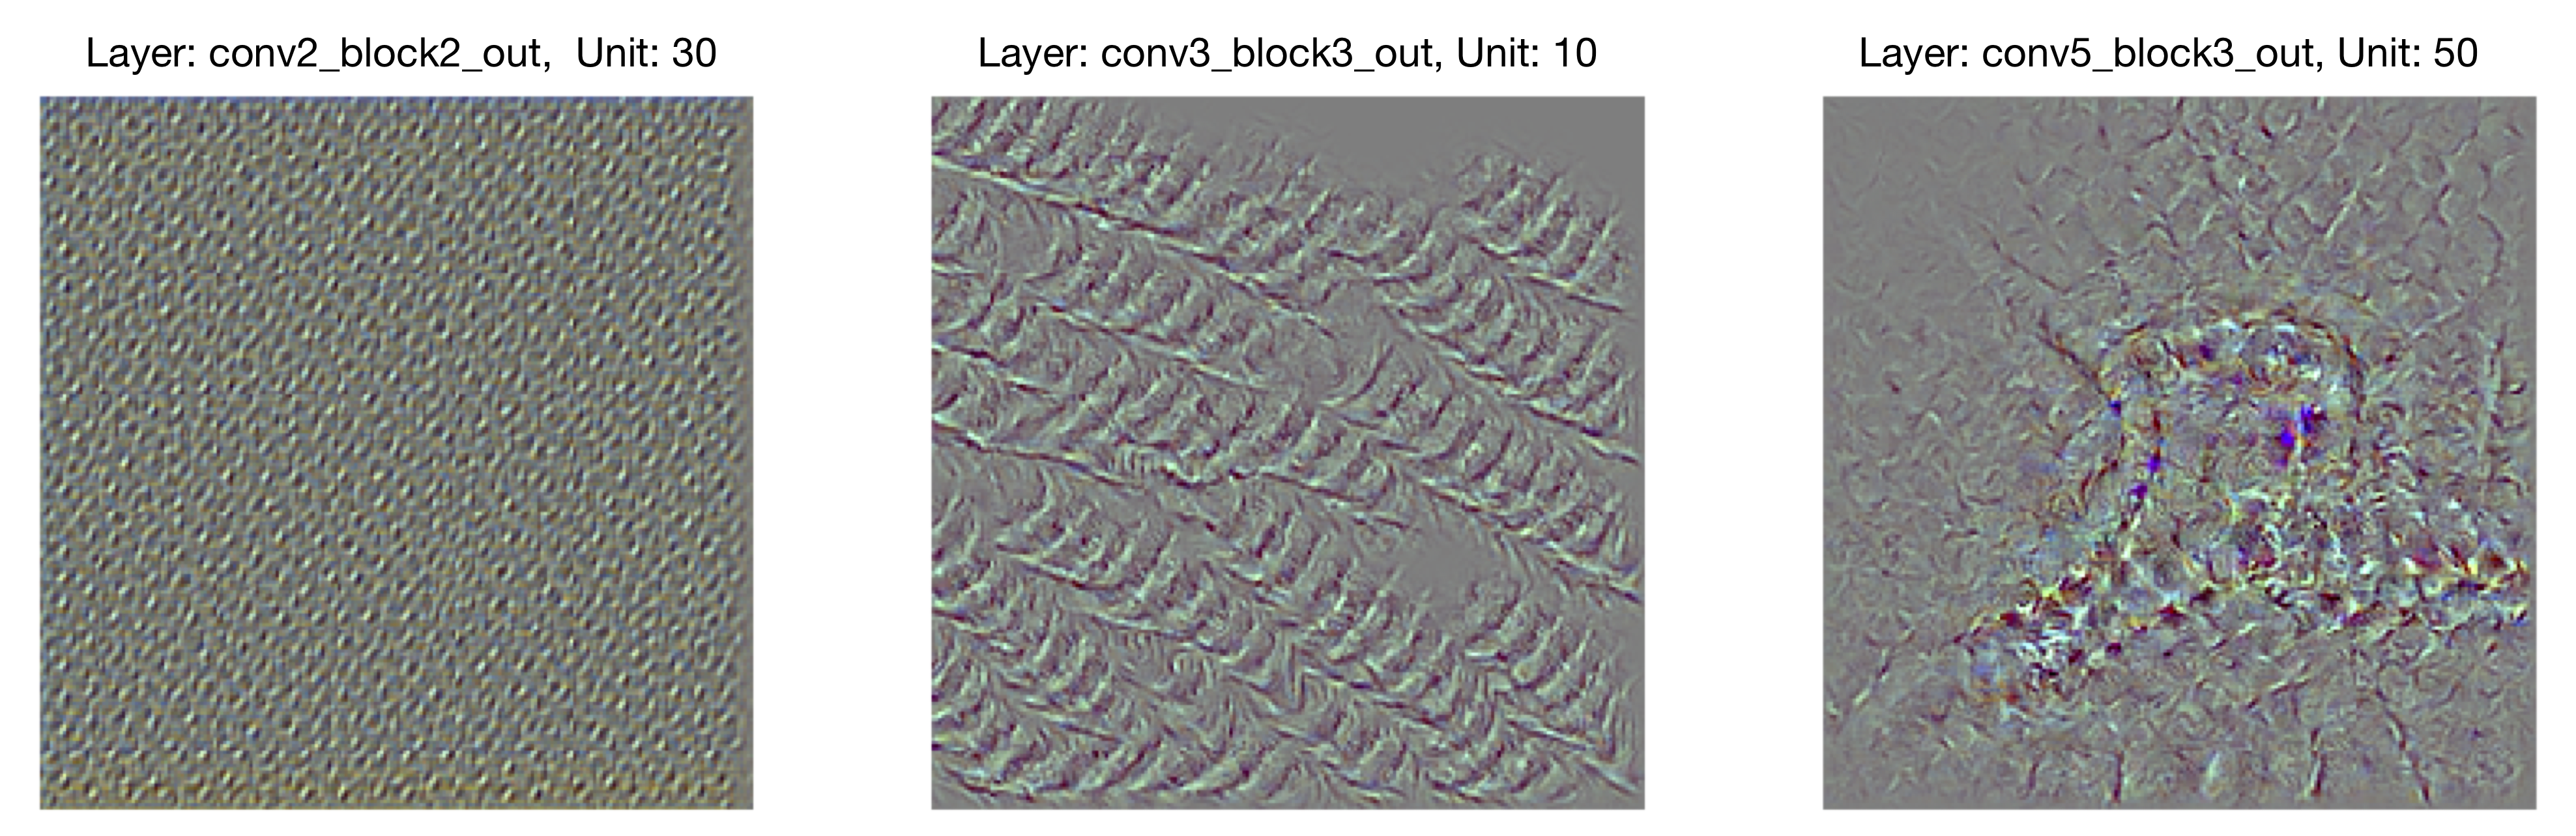

[1] D. Erhan, Y. Bengio, A. Courville, and P. Vincent. Visualizing higher-layer features of a deep network. Technical Report 1341, University of Montreal, Jun 2009. https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf

### Prerequisites

- You should have set up the CS456 virtual conda environment and installed the dependencies as described in the document [Miniprojects | Environment Setup and XOR exercise](https://moodle.epfl.ch/pluginfile.php/2024974/mod_resource/content/6/env_setup.pdf) published on moodle. You should launch this notebook from this environment, i.e. using the CS456 python 3 kernel.
- Following that procedure you should have a running installation of [tensorflow 2](https://www.tensorflow.org/install) which includes the  [keras package](https://keras.io) as a [tensorflow 2 module](https://www.tensorflow.org/guide/keras). Feel free to gain inspiration for model architecture and training procedures from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations. 
  
**Important:** Since we are using tensorflow 2 you have to import Keras (functions) via tensorflow, i.e.   
~~`from keras.models import Sequential`~~  
`from tensorflow.keras.models import Sequential`
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "backpropagation".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will get in contact with concepts discussed in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on how to visualise the learned features in deep neural networks to get some intuition what they actually "learn". 
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server). If you have access to a GPU you can also use the [gpu support of tensorflow 2](https://www.tensorflow.org/install/gpu) to speed up simulations.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answers to the questions. Provide clear and concise answers respecting the indicated maximum length. Keep your code tidy, organised and commented to allow us (and yourself) to understand what is going on. All plots must have axes labels as well as legends and a title where needed.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [81]:
student1 = "Maya Abou Rjeili"
student2 = ""

## Some helpers

For your convenience we provide here some imports and utility functions. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Reshape
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow_datasets as tfds
tf.__version__

'2.1.0'

### Plotting helpers

In [2]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(47)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['accuracy'], label = "training")
    ax2.plot(history['val_accuracy'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd['loss'], label=label1 + ' training')
    ax1.plot(history_sgd['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam['loss'], label=label2 + ' training')
    ax1.plot(history_adam['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd['accuracy'], label=label1 + ' training')
    ax2.plot(history_sgd['val_accuracy'], label=label1 + ' validation')
    ax2.plot(history_adam['accuracy'], label=label2 + ' training')
    ax2.plot(history_adam['val_accuracy'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Callback for history tracking

This callback saves the history ('learning curve') during training of a model using the `tensorflow.keras.model.fit` function. You have the following options: 
- do_print: decides whether the losses and accuracies are printed after every epoch.
- evaluate: either use online estimates for the training loss and training accuracies ('online') or evaluate the model on training and validation set (in eval mode) after every epoch ('after_epoch'). This takes more time but is more accurate.  
**Important:** When using dropout regularisation you should use this setting to get the correct learning curves!

In [3]:
class trackhistory(tf.keras.callbacks.Callback):
    def __init__(self, train_data, test_data, do_print = False, evaluate = 'after_epoch'):
        self.train_data = train_data
        self.test_data = test_data
        self.accuracy = []
        self.loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.do_print = do_print
        self.evaluate = evaluate

    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate == 'after_epoch':
            x_train, y_train = self.train_data
            x_test, y_test = self.test_data
            loss, acc = self.model.evaluate(x_train, y_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(x_test, y_test, verbose=0)
        elif self.evaluate == 'online':
            loss, acc = logs.get('loss'), logs.get('accuracy')
            val_loss, val_acc = logs.get('val_loss'), logs.get('val_accuracy')
        
        self.loss.append(loss)
        self.accuracy.append(acc)
        self.val_loss.append(val_loss)
        self.val_accuracy.append(val_acc)
        if self.do_print:
            print('\ntrain loss: {}, train acc: {}'.format(loss, acc))
            print('\nval loss: {}, val acc: {}\n\n'.format(val_loss, val_acc))
        
# Usage: e.g.
# history = trackhistory((x_train, y_train), (x_test, y_test), 
#                         do_print = True, evaluate = 'after_epoch')
# model.fit(x_train, y_train, batch_size = 128, epochs = 10, verbose = 1, 
#           validation_data = (x_test, y_test), callbacks = [history])

# Part 1: Using Feedforward Neural Networks for classification

In this part we study some basics of image classification using deep feedforward neural networks.  
  
**Remark:** Since model fitting can take considerable time you should consider saving and reloading

1. trained models using the [`tensorflow.keras.models.save_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model) and [`tensorflow.keras.models.load_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) functions,
2. metadata, such as hyperparameters and history objects (i.e. learning curves),

in case you have to restart the kernel of this notebook.

# Exercise 1: Data import, preprocessing and visualization (4 points)

Here we import the EMNIST dataset. We use the 'balanced' version of the dataset, for further details check the [website](https://www.nist.gov/itl/products-and-services/emnist-dataset) or the corresponding [paper](https://arxiv.org/pdf/1702.05373v1.pdf).  

We use the [tensorflow datasets framework](https://www.tensorflow.org/datasets) to import the dataset. Since we are dealing with a relatively small dataset we can convert the data to numpy arrays which makes it easier for us to look at the actual data.

1. Load the 'emnist/balanced' dataset (both training and test data) including the dataset info using the tensorflow dataset framework. Then complete and call the function `get_data_arrays` which converts the data into numpy arrays and transposes the images so that the letters are 'upright' (2 pts).
2. Visualise the dataset by plotting some examples images. Hint: understand and use the provided function `plot_some_samples` (2 pts).

In [4]:
# load data
data, info = tfds.load(name="emnist/balanced",split=None,with_info=True)

In [5]:
def get_data_arrays(data, info, split, num_classes = info.features['label'].num_classes):
    x = np.zeros((info.splits[split].num_examples,) + info.features['image'].shape)
    y = np.zeros((info.splits[split].num_examples, num_classes))
    i = 0
    for d in data[split]:
        # get image, convert it to a numpy array and transpose it so the letters are 'upright'
        x[i, :, :, :] =  d['image'].numpy().transpose(1,0,2)
        # get lables and convert them to one hot coded labels using tf.keras.utils.to_categorical
        y[i, :] = tf.keras.utils.to_categorical(d['label'].numpy(),num_classes)
        i += 1
    return x, y
    
x_train, y_train =  get_data_arrays(data, info, split="train")
x_test, y_test = get_data_arrays(data, info, split="test")

# normalise to range [0, 1]
x_train /= x_train.max()
x_test /= x_test.max()

Figure(432x288)


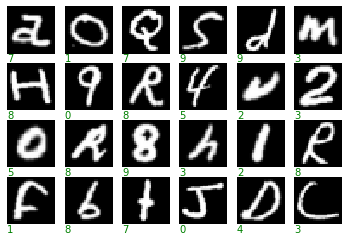

In [20]:
# visualise dataset
print(plot_some_samples(x_train,y_train))

# Exercise 2: Simple Perceptrons (10 pts) 

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of fully connected hidden layers already at this point). Use the [`tensorflow.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class imported as `Sequential` in the above dependencies.

1. Use the softmax activation for the output layer.
2. Use the 'categorical_crossentropy' loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent (SGD, already implemented in Keras) as the optimizer.
5. Choose a minibatch size of 128.
6. Visualise the network you created using the `summary()` method of the `tensorflow.keras.Sequential` class (6 pts for the constructor and fit functions satisfying points 1. - 6.).
7. Fit for as many epochs as needed to see no further decrease in the validation loss (1 pt).
8. Plot the output of the fitting procedure (a history object) using the function `plot_history` defined above (1 pt).
9. Repeat the fit of point 6. using the [Adam optimiser](https://arxiv.org/abs/1412.6980) (also already implemented in Keras) (1 pt).
10. Plot the new learning curves together with the ones of point 7 in a comparison plot (you can use the function `comparison_plot` defined above) and answer to the question in the markdown box below (1 pt).

Hints:
* Read the ([tensorflow.keras](https://www.tensorflow.org/api_docs/python/tf/keras/) or) [keras docs](https://keras.io), in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples) to gain inspiration for network architectures.  
**Important:** Since we are using tensorflow 2 you have to import Keras (functions) via tensorflow (see Introduction/Prerequisites).



In [6]:
x_train_reshaped=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test_reshaped=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

In [7]:
# define models
# you can create a generic constructor function for MLPs
def generic_constructor(layers_dim=[784,47],dropout=0,activation='relu',activation_out='softmax',loss='categorical_crossentropy',optimizer='SGD',metrics='accuracy',epochs=20,batch_size=128,model_name='SP'):
    model=Sequential()
    L = len(layers_dim)
    if(L>2):
        model.add(Dense(layers_dim[1],input_dim=layers_dim[0],activation=activation))
        for l in range(2,L-1):
            model.add(Dropout(dropout))
            model.add(Dense(layers_dim[l],activation=activation))
        model.add(Dropout(dropout))    
        model.add(Dense(info.features['label'].num_classes,activation=activation_out))
    elif(L==2):
        model.add(Dense(info.features['label'].num_classes,input_dim=layers_dim[0],activation=activation_out))
    
    summary=model.summary()
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics])
    history=model.fit(x_train_reshaped[0:94000], y_train[0:94000],
            epochs=epochs,
            batch_size=batch_size,
            verbose=2,
            validation_data=(x_train_reshaped[94000:112801],y_train[94000:112801])) #Based on the paper comment that "the last portion of the training set, equal in size to the testing set, is set aside as a validation set."
    score = model.evaluate(x_test_reshaped, y_test, batch_size=batch_size,verbose=0)
    tf.keras.models.save_model(model,"saved_models\\{}".format(model_name))
    return summary,history,score

In [39]:
# create and fit your model
summary_SGD,history_SGD,score_SGD=generic_constructor(epochs=200)
print('Test loss:', score_SGD[0])
print('Test accuracy:', score_SGD[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 47)                36895     
Total params: 36,895
Trainable params: 36,895
Non-trainable params: 0
_________________________________________________________________
Train on 94000 samples, validate on 18800 samples
Epoch 1/200
94000/94000 - 4s - loss: 3.1636 - accuracy: 0.2728 - val_loss: 2.6105 - val_accuracy: 0.4462
Epoch 2/200
94000/94000 - 3s - loss: 2.3136 - accuracy: 0.4949 - val_loss: 2.1050 - val_accuracy: 0.5242
Epoch 3/200
94000/94000 - 3s - loss: 1.9658 - accuracy: 0.5428 - val_loss: 1.8729 - val_accuracy: 0.5513
Epoch 4/200
94000/94000 - 3s - loss: 1.7887 - accuracy: 0.5643 - val_loss: 1.7413 - val_accuracy: 0.5690
Epoch 5/200
94000/94000 - 3s - loss: 1.6812 - accuracy: 0.5793 - val_loss: 1.6566 - val_accuracy: 0.5811
Epoch 6/200
94000/94000 - 3s - loss: 1.6078 - accuracy: 0.5903 - val_

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models\SP\assets


INFO:tensorflow:Assets written to: saved_models\SP\assets


Test loss: 1.158614632423888
Test accuracy: 0.6905851


Figure(432x288)


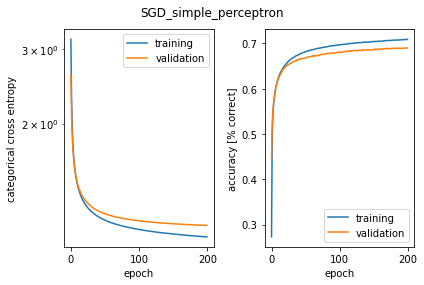

In [40]:
#plot output of model
print(plot_history(history_SGD.history, 'SGD_simple_perceptron'))

In [224]:
# create and fit your model
summary_adam,history_adam,score_adam=generic_constructor(optimizer='adam',epochs=200,model_name='SP_adam')
print('Test loss:', score_adam[0])
print('Test accuracy:', score_adam[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 47)                36895     
Total params: 36,895
Trainable params: 36,895
Non-trainable params: 0
_________________________________________________________________
Train on 94000 samples, validate on 18800 samples
Epoch 1/200
94000/94000 - 7s - loss: 1.6443 - accuracy: 0.5816 - val_loss: 1.2973 - val_accuracy: 0.6507
Epoch 2/200
94000/94000 - 4s - loss: 1.2238 - accuracy: 0.6685 - val_loss: 1.2181 - val_accuracy: 0.6673
Epoch 3/200
94000/94000 - 3s - loss: 1.1653 - accuracy: 0.6829 - val_loss: 1.1942 - val_accuracy: 0.6715
Epoch 4/200
94000/94000 - 4s - loss: 1.1379 - accuracy: 0.6909 - val_loss: 1.1779 - val_accuracy: 0.6774
Epoch 5/200
94000/94000 - 3s - loss: 1.1211 - accuracy: 0.6958 - val_loss: 1.1656 - val_accuracy: 0.6846
Epoch 6/200
94000/94000 - 4s - loss: 1.1089 - accuracy: 0.6997 - val_

INFO:tensorflow:Assets written to: saved_models\SP_adam\assets


Test loss: 1.2100498209608361
Test accuracy: 0.68106383


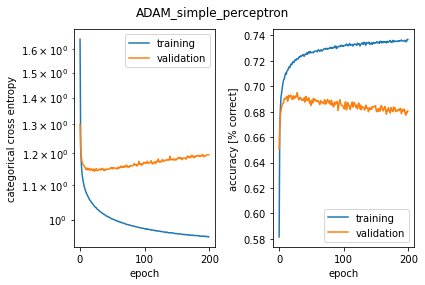

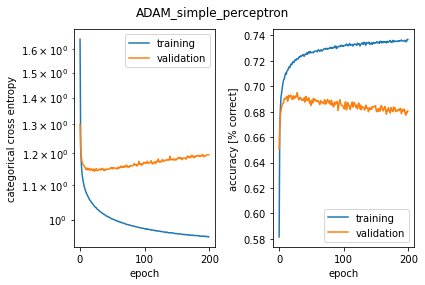

In [22]:
#plot output of model
plot_history(history_adam.history, 'ADAM_simple_perceptron')

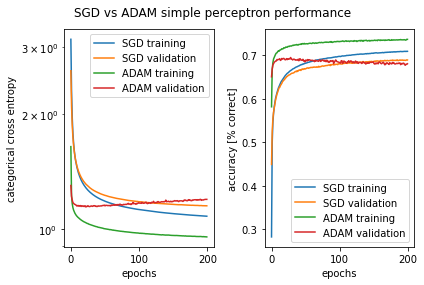

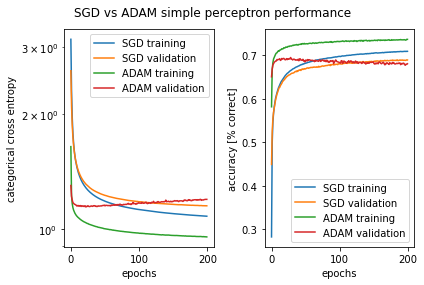

In [23]:
# comparison plot
comparison_plot(history_SGD.history, history_adam.history, 'SGD', 'ADAM', 'SGD vs ADAM simple perceptron performance')

**Question**: How do the learning curves change when replacing the SGD optimiser by the Adam optimiser? Please answer with one full sentence.

(double click this markdown cell to edit).

**Answer**: Adam optimiser learns much faster than SGD optimiser. The best performance for Adam is seen after 15 epochs while for SGD it starts after 100+ epochs

# Exercise 3: Multi-layer Perceptrons (MLP), overfitting and dropout (10 pts)  

In this exercise we will use a Multi-layer Perceptron with multiple, fully-connected (dense), hidden layers to explore overfitting in neural networks. 

1. Create a model with 2 or 3 fully-connected, hidden layers with 500 hidden neurons each. Hidden layers should have a `relu` nonlinearity and the last layer a `softmax` nonlinearity. Use the `categorical_crossentropy` loss. Include the option of having a [dropout layer](https://arxiv.org/abs/1207.0580) after each hidden layer in your constructor function (2 pts).
2. Use the Adam optimiser, train the model for at least 10 epochs and plot the learning curves. No dropout should be used for this simulation (2 pts).
3. Answer question 1. in the below markdown box
4. Include dropout layers into your MLP and experiment with different dropout rates. Once you have obtained learning curves that differ qualitatively from the ones in point 2., plot all of them together in a comparison plot (2 pts).
5. Discuss the effect of dropout by answering question 2 in the below markdown box (2 pts).


In [28]:
# model with 2 hidden layers and no dropout
summary_MLP2,history_MLP2,score_MLP2=generic_constructor(layers_dim=[784,500,500,47],optimizer='adam',epochs=25,model_name="MLP")
print('Test loss:', score_MLP2[0])
print('Test accuracy:', score_MLP2[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 47)                23547     
Total params: 666,547
Trainable params: 666,547
Non-trainable params: 0
_________________________________________________________________
Train on 94000 samples, validate on 18800 samples
Epoch 1/25
94000/94000 - 8s - loss: 0.9323 - accuracy: 0.7226 - 

INFO:tensorflow:Assets written to: saved_models\MLP\assets


Test loss: 0.9401770938710964
Test accuracy: 0.83840424


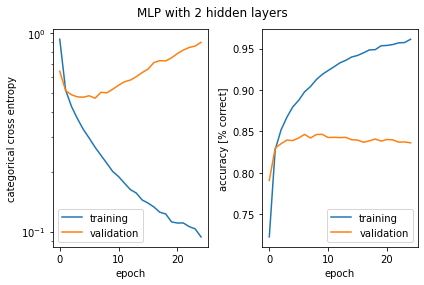

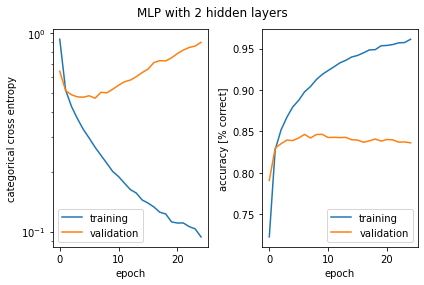

In [29]:
plot_history(history_MLP2.history, 'MLP with 2 hidden layers')

In [30]:
# model with 2 hidden layers and dropout
summary_MLP2drop,history_MLP2drop,score_MLP2drop=generic_constructor(layers_dim=[784,500,500,47],dropout=0.3,optimizer='adam',epochs=25,model_name="MLP_dropout")
print('Test loss:', score_MLP2drop[0])
print('Test accuracy:', score_MLP2drop[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 47)                23547     
Total params: 666,547
Trainable params: 666,547
Non-trainable params: 0
_________________________________________________________________
Train on 94000 samples, validate on 18800 samples
Epoch 1/25
94000/94000 - 9s - loss: 1.1712 - accuracy: 0.6545 - 

INFO:tensorflow:Assets written to: saved_models\MLP_dropout\assets


Test loss: 0.45424306907552353
Test accuracy: 0.85824466


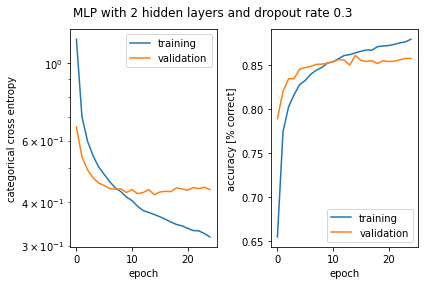

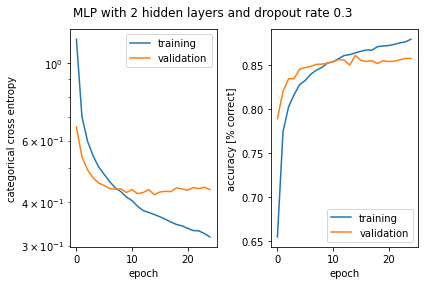

In [31]:
plot_history(history_MLP2drop.history, 'MLP with 2 hidden layers and dropout rate 0.3')

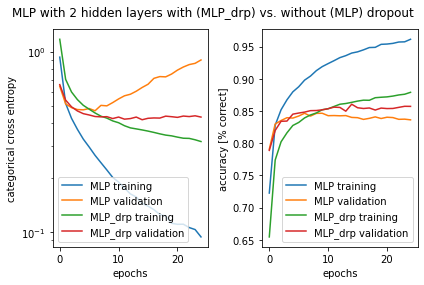

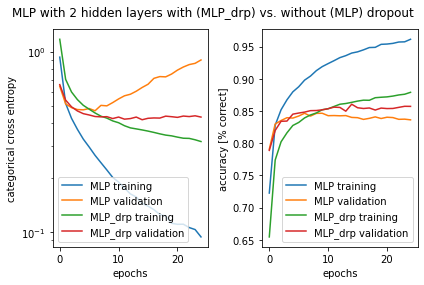

In [32]:
# comparison plot
comparison_plot(history_MLP2.history, history_MLP2drop.history, 'MLP', 'MLP_drp', 'MLP with 2 hidden layers with (MLP_drp) vs. without (MLP) dropout')

**Question 1** What is the qualitative difference between training and validation learning curve? How can you explain this behaviour? (2 sentences max.)

**Answer** : The training curve loss and accuracy keep decreasing with more epochs but the validation curves plateau after few epochs. This is due to overfitting.

**Question 2** How are the dropout layers changing the learning curves? How can we understand this influence of these layers? (2 sentences max.)

**Answer** : The dropout layers lower the loss/accuracy on the training curve and it's much closer to the validation curve, the validation curve shows a better performance with dropout. Dropout layers reduce overfitting.

# Exercise 4: Convolutional Neural Networks (CNN) (10 pts)

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network and play with different architectures and parameters. Use at least 2 to 3 convolutional layers and one fully-connected layer between convolutional layers and output layer. You may want to use dropout for the fully-connected layers. Use a softmax nonlinearity for the output and categorical crossentropy loss as before. Your CNN model should significantly outperform the above MLPs for reasonable hidden layer sizes. Please visualise your best performing CNN using the `summary` method. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples) (4 pts).
2. Plot the learning curves of the best convolutional neural network you found for the EMNIST dataset (2 pts).
3. Answer to the questions in the markdown box below (4 pts).


In [260]:
input_shape=info.features['image'].shape
epochs=25
batch_size=128
num_classes=info.features['label'].num_classes

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history=model.fit(x_train[0:94000], y_train[0:94000],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_train[94000:112801], y_train[94000:112801]))

score = model.evaluate(x_test, y_test, verbose=0)
tf.keras.models.save_model(model,"saved_models\\CNN")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 128)               1179776   
_________________________________________________________________
dropout_103 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 47)              

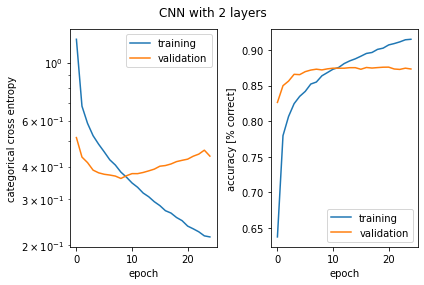

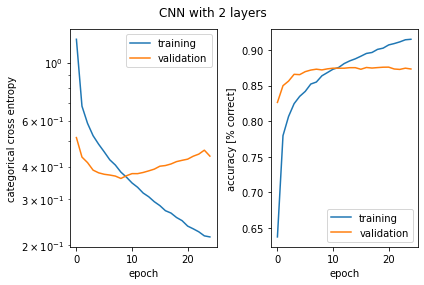

In [261]:
plot_history(history.history, 'CNN with 2 layers')

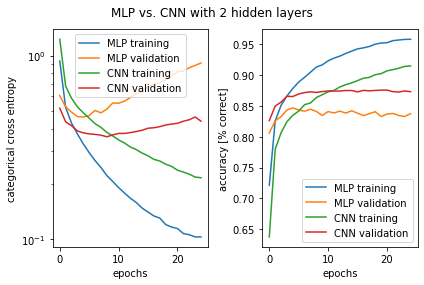

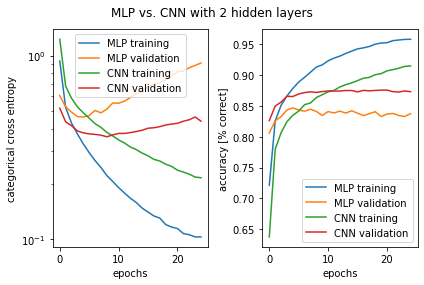

In [262]:
# comparison plot
comparison_plot(history_MLP2.history, history.history, 'MLP', 'CNN', 'MLP vs. CNN with 2 hidden layers')

**Question 1** How does the CNN performance compare to the so far best performing MLP model for the EMNIST data set? (1 sentence max.)

**Answer** : There is around 4% improvement on the MLP without dropout and 2% for the MLP with dropout, it's a small improvement.

**Question 2** Seeing an MLP as a general function approximator, the convolutional architecture is actually a restriction to that generality. How can you explain that CNNs are still performing better on image classification tasks? (2 sentences max.)

**Answer** : They provide a better explicit inductive bias. Images are a special type of data as the location of each pixel matters and we are interested in how pixels together form some shape as oposed to the value of a single pixel. MLP doesn't take into account the location of the pixels and doesn't understand as efficiently that shapes are formed with pixels that are nearby.

**Question 3** Standard CNNs are computationally heavy models compared to standard MLPs and training a CNN for one epoch could take e.g. 5 times longer than for an MLP (not taking GPUs into account). That means that in a CNN there are many more operations (like multiplications and additions) taking place per input than in an MLP. However, you might notice that your CNN has a comparable or even smaller number of trainable parameters than the MLPs before. How is this possible? (2 sentences max.)

**Answer** A convolutional layer has more operations since each filter moves over the image and repeats the multiplaction/summation at each position. But the number of trainable parameters is smaller because many neurons have the same weights and many weights are zero, except in a small neighborhood.

# Part 2: Feature visualisation

In this second part of the project we use standard and non-standard ways of visualising learned features in deep neural networks. We will refer to these 'learned features' or 'prefered stimuli' of a given neuron in the network as '[receptive fields](https://en.wikipedia.org/wiki/Receptive_field)' - a term borrowed from neuroscience.

**Remark:** For the following exercies it will be useful to get an overview over the network structure of the models such as layer names. For this you can use either the `model.summary()` method or layer dictionaries: `layer_dict = dict([(layer.name, layer) for layer in model.layers])`

# Exercise 5: Plotting the weights (10 pts)

The easist and most straighforward way to investigate learned features in an artificial neural network is to directly look at the learned incoming weights to a given neuron. For the first layer's weights we can actually display them as an image since they 'live' in the same space as the input - i.e. in the image space.

1. Find a way to access the weights of the first layer of a `Sequential` model and transform them into a numpy array. Hint: `get_layer()`, `_trainable_weights` (1 pt).
2. Write a function `plot_weights` that takes the extracted weights as a numpy array and plots the incoming weights of N^2 neurons in the first hidden layer in a NxN grid of `plt.imshow()` image plots. Make your function suitable for both, fully-connected layers and convolutional layers (3 pt).
3. Plot the incoming weights for some (e.g. N = 5) neurons in the first (= only) layer of a simple perceptron (SP) (1 pt).
4. Do the same plotting as in point 3. for the first layer of your best MLP (1 pt).
5. Do the same plotting as in point 3. for the first layer of your CNN (1 pt).
6. Discuss what you observe by answering the question in the markdown box below (3 pt).


In [11]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'conv2d_10': <tensorflow.python.keras.saving.saved_model.load.Conv2D at 0x205fa1e5d88>,
 'conv2d_11': <tensorflow.python.keras.saving.saved_model.load.Conv2D at 0x205fa1eaa88>,
 'max_pooling2d_5': <tensorflow.python.keras.saving.saved_model.load.MaxPooling2D at 0x205fa1f0448>,
 'flatten_5': <tensorflow.python.keras.saving.saved_model.load.Flatten at 0x205fa1f0d48>,
 'dense_186': <tensorflow.python.keras.saving.saved_model.load.Dense at 0x205fa1f27c8>,
 'dropout_103': <tensorflow.python.keras.saving.saved_model.load.Dropout at 0x205fa1f2ec8>,
 'dense_187': <tensorflow.python.keras.saving.saved_model.load.Dense at 0x205fa1f5888>}

In [9]:
def plot_weights(weights, N, NN_type="conv"):
    
    fig, a = plt.subplots(N,N)
    for i in range(N):
        for j in range(N):
            if NN_type == 'conv':
                a[i,j].imshow(weights[:,:,0,i*N+j])
            if NN_type == 'FC':
                a[i,j].imshow(weights[:,:,i*N+j])
    return fig

### Simple Perceptron

Figure(432x288)


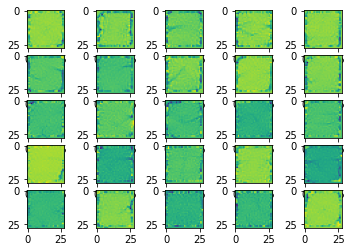

In [275]:
# layer_id = ... # e.g. 'dense_1'. Can be read from the model.summary() or a layer dictionary
model = tf.keras.models.load_model("saved_models\\SP_adam")
w_SP = model.trainable_weights[0].numpy()
w_SP = w_SP.reshape(28,28,47)
print(plot_weights(w_SP, 5, 'FC'))

### Multi Layer Perceptron

Figure(432x288)


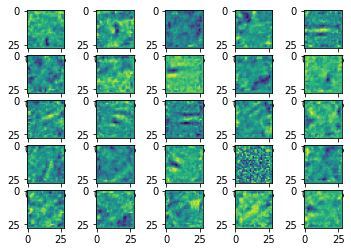

In [136]:
model = tf.keras.models.load_model("saved_models\\MLP_dropout")
w_MLP = model.trainable_weights[0].numpy()
w_MLP = w_MLP.reshape(28,28,500)
print(plot_weights(w_MLP, 5, 'FC'))

### CNN

Figure(432x288)


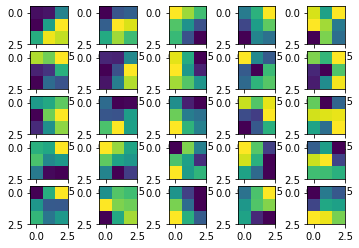

In [10]:
model = tf.keras.models.load_model("saved_models\\CNN")
w_CNN = model.trainable_weights[0].numpy()
print(plot_weights(w_CNN, 5))

**Question 1** Describe the 'receptive fields' you obtained for the simple perceptron (SP). Can you explain their appearance given the fact that the corresponding neurons are the output neurons of this network? (2 sentences max.)

**Answer** We can see the shapes of each digit/letter. For the SP, each neuron in the output layer corresponds to a digit/number label and when predicting, we take the dot product of the weights of this neuron with the input image, which will measure how similar the input image is the the weights of the neuron.


**Question 2** Describe the 'receptive fields' you obtained for the MLP. How do they compare to the SP ones? (2 sentences max.)

**Answer** Now each perceptron does not correspond to a specific label. Instead, it is recognizing lower level features. We can see circles and parts of circles of different sizes as well as edges in different directions.

**Question 3** Explain the dimensions of the CNN filters. Can we interpret the learned features as for the SP or MLP?

**Answer** The dimension of the CNN filters (3x3 in my case) is smaller than the dimension of the whole image and will only go throught each parts of the input image one at the time as opposed to looking at the whole image like for the SP and MLP. We can still interpret the learned features as detercting low level features in a similar way as for the MLP except it will look for these features for each parts of the image and thus the scaling is very different.

# Exercise 6: Maximaly activating patch/image method (10 pts)

Another easy way to get an intuition what a specific neuron codes for is to look at the input images that maximise its activity the most. To this end you should:

1. Complete the function `get_mean_filter_response` to extract the (spatially averaged) responses of a neuron to every input image in the test set (to save some computation time) (2 pts).
2. For your CNN model, extract the indices of the N^2 input images (for N = 5) that caused the highest response in one arbitrary unit in an arbitrary layer (1 pt).
3. Plot the corresponding N^2 input images in a NxN grid (using `plt.imshow()` for every image in the grid) (1 pt).
4. Do this plot for several units (e.g. 3 different ones) in the first (conv.) layer, a middle layer and the last trainable (fully-connected) layer of your model (3 pts).
5. Describe what you observed by anwering the questions in the below markdown box (3 pts).


In [38]:
model_conv = tf.keras.models.load_model("saved_models\\CNN")
model_conv.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 128)               1179776   
_________________________________________________________________
dropout_103 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 47)              

In [17]:
def get_mean_filter_response(model, data, layer_id, filter_id):
    # Define a new model which outputs the activity of a specific layer
    aux_model = tf.keras.Model(inputs=model.inputs[0], outputs=model.get_layer(layer_id).output)
    inter_layer_output = aux_model(data).numpy()
    # fully connected layer case: mean_responses are simply a slice of inter_layer_output for the unit 'filter_id'
    if len(inter_layer_output.shape) == 2:
        mean_responses = inter_layer_output[:,filter_id]
    # conv layer case: take slice for unit 'filter_id' and average (np.mean) over the two spatial dimensions
    elif len(inter_layer_output.shape) == 4:
        mean_responses = np.mean(inter_layer_output[:,:,:,filter_id],axis=(1,2))
    
    return mean_responses


# layer_id =  # e.g. 'conv2d'. Can be read from the model.summary() or a layer dictionary
# filter_id = # e.g. 10
    
# mean_responses = get_mean_filter_response(model_conv, x_test, layer_id, filter_id)

In [18]:
# plotting
def plot_activation(model,data,layer_id,filter_id,N=5):
    mean_responses=get_mean_filter_response(model, data, layer_id, filter_id)
    indices=mean_responses.argsort()[-N**2:][::-1]

    fig, a = plt.subplots(N,N)
    for i in range(N):
        for j in range(N):
            pos=indices[i*N+j]
            a[i,j].imshow(data[pos][:,:,0])
        
    return fig

Figure(432x288)


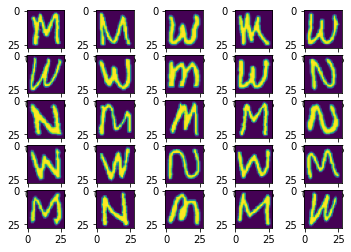

In [15]:
#First conv. layer
print(plot_activation(model_conv,x_test,'conv2d_10',10))

Figure(432x288)


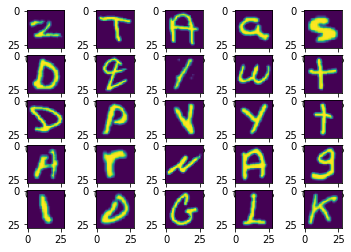

In [16]:
#Second conv layer
print(plot_activation(model_conv,x_test,'conv2d_11',10))

Figure(432x288)


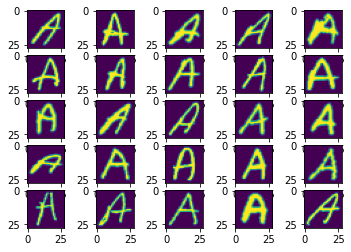

In [41]:
#Last trainable Fully connected layer
print(plot_activation(model_conv,x_test,'dense_187',10))

Looking at the input images that maximize activity in specific units, what can you say about the features they code for in the case of (1 sentence max. for each question):

**Question 1** the first (convolutional) layer?  
**Anwer** it looks for low level features like vertical and horizontal lines and thickness.

**Question 2** an intermediate layer?  
**Answer**  it looks for higher level features like line crossing and curves

**Question 3** the last trainable (fully-connected) layer?  
**Answer** it classifies the image, each filter corresponds to a class

# Exercise 7: Reverse Correlation (8 pts)

In this exercise we use a method known from neuroscience called '[Reverse Correlation](https://en.wikipedia.org/wiki/Spike-triggered_average)' or 'Spike-triggered average' to visualise linear learned filters - or '[receptive fields](https://en.wikipedia.org/wiki/Receptive_field)', as a neuroscientis would say. The idea is to correlate every input image ('trigger') with its response ('spike') in a certain unit and then average over whole dataset.

1. Complete the function `get_rev_cor` that computes the reverse correlation of a unit as described above. Use the function `get_mean_filter_response` from above to get the response of a unit for all input images in the test set (1 pt).
2. Plot the reverse correlation of one or two units in the first layer of the CNN model as an image (1 pt).
3. Plot the reverse correlation of one or two units in a middle layer of the CNN model as an image (1 pt).
4. Plot the reverse correlation of one or two output units in the last layer of the CNN model as an image (1 pt).
5. Plot the mean image of the test set, i.e. a reverse correlation assuming a unit responds with the exact same value to all images (1 pt).
6. Discuss your results by answering the question in the markdown box below (3 pt).


In [15]:
def get_rev_cor(model, data, layer_id, filter_id):
    # get (mean) responses for all images in 'data'
    mean_responses = get_mean_filter_response(model, data, layer_id, filter_id)
    # product with data
    rev_cor_product = np.transpose(np.multiply(np.transpose(x_test, (3, 1, 2, 0)), mean_responses), (3, 1, 2, 0))
    # average rev_cor_product over data dimension to get reverse correlation
    rev_cor = np.average(rev_cor_product,axis=0)
    
    return rev_cor


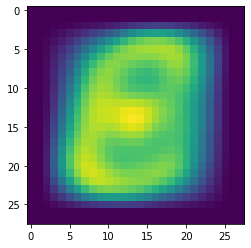

In [108]:
# Call 'get_rev_cor' and plotting
#First conv layer
rev_corr1=get_rev_cor(model_conv,x_test,'conv2d_10',20)
plt.imshow(rev_corr[:,:,0])

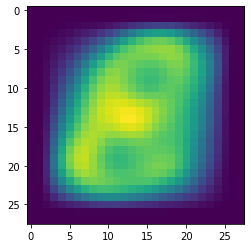

In [43]:
#Second conv layer
rev_corr2=get_rev_cor(model_conv,x_test,'conv2d_11',11)
plt.imshow(rev_corr2[:,:,0])

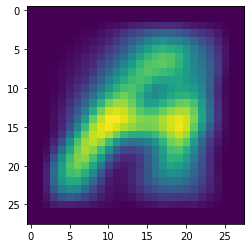

In [26]:
#output layer
rev_corr3=get_rev_cor(model_conv,x_test,'dense_187',10)
plt.imshow(rev_corr3[:,:,0])

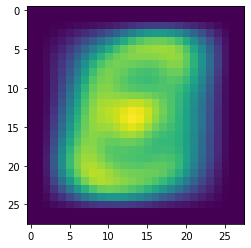

In [42]:
#mean image of test set
rev_corr4=np.average(x_test, axis=0)
plt.imshow(rev_corr4[:,:,0])

**Question 1** Why does reverse correlation NOT give an insightful image for lower and middle layers? (1 sentence max.)

**Answer** The inputs that  give a maximal response to each neuron generally include a very wide range of letters/numbers. Reverse correlation is average of the shapes of all the letters and numbers.

**Question 2** How is the average image of the test set related to these unsatisfying reverse correlation images? (1 sentence max.)

**Answer** They look similar which makes sense since in the lower and middle layers are also the average of all letters and numbers.

**Question 3** Interpret the reverse correlation image for the output neurons. Why is it meaningful and would this also work for harder data sets where objects of the same class occur e.g. at different positions in the image? (2 sentences max.)

**Answer** The image is an average of the inputs that the model predicts having the label corresponding to each neuron. It's meaningful in our example as the inputs corresponding to the same label are very similar and thus averaging them gives us something that look like each of them but it wouldn't be as nice/meaningful if the data was more complicated.

# Exercise 8: Gradient method (10 pts)

After the 'standard methods' above we now look at a more elaborate method for visualising features of deep neural networks that can lead to such cool images as shown in the introduction of this notebook.  

The basic idea is to use the power of backpropagation to look for a 'maximally activating image' that activiates a certain unit as much as possible: We define the activity of a unit as the loss and then iteratively create an image by updating proportionally to the gradient of this loss with respect to the pixels.  

This idea was published first in [1] and the version we will implement (especially the simple, yet effective gradient normalisation trick) is inspired by the tutorial in [2] (**Careful:** This tutorial is using Keras under Tensorflow 1, so do not copy paste their code here since it will not work with tensorflow 2!).

1. Read the basics [1, 2] about the gradient method and understand the provided functions below. Then answer to the questions in the markdown box below (2 pts).
2. Complete the function `get_max_act_stim` using the provided functions (2 pts).
3. Calculate the 'maximally activating image' for one or more arbitrary units in three different layers (first, middle, last) of your CNN model and plot the results as images. Some units might not respond to any input image and should be ignored. You can use the `post_process_image` function at this point but results should not change dramatically for CNNs trained on EMNIST (3 pts).
5. Discuss the results by answering the question in the markdown box below (1 pts).
4. Now that we are experts in this method we step to bigger networks with richer features. Download a big CNN model, e.g. ResNet50, which was pretrained on ImageNet from the [Keras applications webpage](https://www.tensorflow.org/api_docs/python/tf/keras/applications) using `from tensorflow.keras import applications`. In case you want to save disk space, make sure you only download the convolutional/pooling layers of the model since the fully-connected layers can be quite huge in terms of memory. Plot the resulting images for at least three different units in different layers (use the `post_process_image` function to obtain nice plots with `plt.imshow()`) (2 pts).

[1] D. Erhan, Y. Bengio, A. Courville, and P. Vincent. Visualizing higher-layer features of a deep network. Technical Report 1341, University of Montreal, Jun 2009. (https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf)

[2] https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html


In [95]:
from tensorflow.keras import backend as K

def get_image_seed(aux_model, img_size = 224):
    # if input image size can be chosen (e.g. vgg16 without top)
    if aux_model.inputs[0].shape[1] == None: 
        return tf.Variable(np.float32(np.random.random((1, img_size, img_size, aux_model.input[0].shape[-1]))))
    # if the model has fixed input image size
    else:
        return tf.Variable(np.float32(np.random.random((1,) + aux_model.input[0].shape)))

def get_image_update_step(aux_model, filter_id, input_img, stepsize = 1):
    def _getgrads(aux_model, input_img):
        with tf.GradientTape() as tape:
            inter_layer_output = aux_model(input_img)
            if len(inter_layer_output.shape) == 2: # FC case
                loss = inter_layer_output[:,filter_id]
            elif len(inter_layer_output.shape) == 4: # conv layer case: spatial average
                loss = K.mean(inter_layer_output[:, :, :, filter_id])    
        # loss is now defined as output of unit 'filter_id'
        # take gradient of loss w.r.t. the input image
        return tape.gradient(loss, input_img)[0]
    
    # calulate gradient
    grads = _getgrads(aux_model, input_img)
    # normalization trick: we normalize the gradient as a regularisation
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)     
    return grads * stepsize

def get_max_act_stim(model, layer_id, filter_id, n_steps = 25):
    aux_model = tf.keras.Model(inputs=model.inputs[0], outputs=model.get_layer(layer_id).output)
    # get an image seed
    input_img = get_image_seed(aux_model)

    i = 0
    n_resets = 0
    while i<n_steps:  # run gradient ascent for n_step steps
        # get image update using 'get_image_update_step'
        update = get_image_update_step(aux_model, filter_id, input_img)
        # this is needed to prevent endless loops
        if np.sum(update) == 0:
            print('loss and update is 0, restart with new image seed')
            input_img = get_image_seed(aux_model)
            i -= i
            n_resets += 1
            if n_resets > 100:
                raise Exception('reset image seed 100 times! exiting now')
        
        # convert update to numpy array, 
        # reshape it to the shape of 'input_img',
        # and add update to image using 'tensor.assign_add()''
        input_img.assign_add(update.numpy().reshape(input_img.shape))
        
        # normalise image after update
        # looks pretty much the same as normalising the gradient in 'get_image_update_step'
        input_img.assign(input_img / (K.sqrt(K.mean(K.square(input_img))) + 1e-5)) 
        i += 1
    
    print('reseted image seed ' + str(n_resets) + ' times')
    return input_img

# this is needed for visualisation. It shifts the distribution and clips outliers
def post_process_image(x, n_of_stds = 5):
    std = np.std(x)
    x = np.clip(x, -n_of_stds * std, n_of_stds * std)
    x -= x.min()
    x /= x.max()
    return x

reseted image seed 0 times


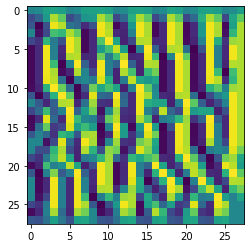

In [96]:
# apply your function 'get_max_act_stim' to your CNN and plot the results...
#first layer
max_act_1=get_max_act_stim(model_conv,'conv2d_10',10)

# plotting
plt.imshow(max_act_1[0,:,:,0])

reseted image seed 0 times


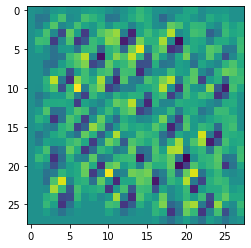

In [97]:
#middle layer
max_act_2=get_max_act_stim(model_conv,'conv2d_11',11)
plt.imshow(max_act_2[0,:,:,0])

reseted image seed 0 times


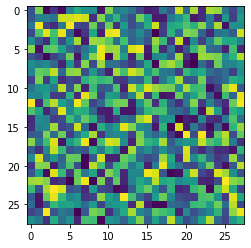

In [98]:
#output layer
max_act_3=get_max_act_stim(model_conv,'dense_187',10)
plt.imshow(max_act_3[0,:,:,0])

**Question 1** What is the image we start from for creating the maximally activating image and what are we updating at every step of the creation? (2 sentences max.)

**Answer** We start with random noise with the shape of an input image that we update at every step so that this random noise turn into an image that maximally activates the desired neuron.

**Question 2** Explain what the function `_getgrads()` implements. Gradients of what and with respect to what are taken? (2 sentences max.)

**Answer** It computes the gradient of the activation of the specified neuron with respect to the input image.

**Question 3** Describe the qualitative change between the maximally optimising images we get for different layers. (2 sentences max.)

**Answer** For the first (conv) layer, we get images with a lot of similarly oriented line. For example one neuron is looking for vertical line and an input image that would maximally activate contains a lot of vertical lines. For the second layer, we see blobs of different shapes. The last layer looks like a not very significant blob but the model will predict with confidence that it should be labeled with the label corresponding to this neuron.

### Big pretrained CNN Feature visualisation

In [89]:
from tensorflow.keras import applications

model_bigCNN = applications.ResNet50(include_top=False, weights='imagenet')
model_bigCNN.summary()

94773248/94765736 [==============================] - 14s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_________________________

reseted image seed 0 times


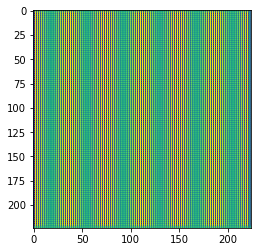

In [104]:
# apply your function 'get_max_act_stim' to the big pretrained CNN and plot the results...
max_act_1=get_max_act_stim(model_bigCNN,'conv1_conv',10)
max_act_1=post_process_image(max_act_1[0,:,:,0])
plt.imshow(max_act_1)

reseted image seed 0 times


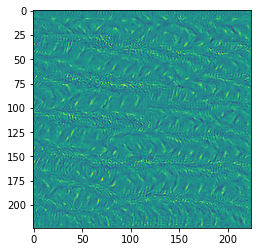

In [106]:
max_act_2=get_max_act_stim(model_bigCNN,'conv3_block2_2_conv',10)
max_act_2=post_process_image(max_act_2[0,:,:,0])
plt.imshow(max_act_2)

reseted image seed 0 times


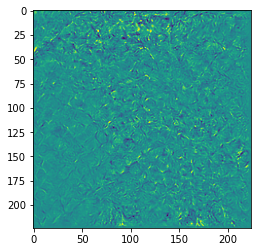

In [107]:
max_act_3=get_max_act_stim(model_bigCNN,'conv5_block3_3_conv',10)
max_act_3=post_process_image(max_act_3[0,:,:,0])
plt.imshow(max_act_3)

## Follow up reading on the gradient method

In case you got interested in this type of visualisation methods for DNNs check out [this paper](https://arxiv.org/pdf/1506.06579.pdf) on extensions of the above gradient method with more sophisticated regularisation schemes. Have fun exploring ;)